# Plot the wind anomalies
Data downloaded from Copernicus Marine Service, product `WIND_GLO_PHY_CLIMATE_L4_MY_012_003`.

In [95]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import calendar
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
coast_l = cfeature.GSHHSFeature(scale="l")
coast_f = cfeature.GSHHSFeature(scale="f")

datacrs = ccrs.PlateCarree()
plt.style.use("filament.mplstyle")

In [98]:
regionname = "Canary"
regions_coords = {"MedSea": (-7, 17, 30., 48.),
                  "Canary": (-18.5, -13., 26., 31),
                  "Atlantic": (-80., 0., 0., 40.),
                  "Balearic": (1., 4.5, 38.5, 40.25),}
coordinates = regions_coords[regionname]

myproj = ccrs.Mercator(central_longitude=0.5 * (coordinates[0] + coordinates[1]), 
                              min_latitude=coordinates[2], max_latitude=coordinates[3])
myproj

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=-15.75 +x_0=0.0 +y_ ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [2]:
datadir = "/home/ctroupin/data/Wind/"
datafile = os.path.join(datadir, "cmems_obs-wind_glo_phy_my_l4_P1M_1720682843981.nc")

In [149]:
eastward_stress_mean = np.zeros((12, len(ds["latitude"]), len(ds["longitude"])))
northward_stress_mean = np.zeros((12, len(ds["latitude"]), len(ds["longitude"])))

with xr.open_dataset(datafile) as ds:
    # Get the indices for the different month
    month_idxs = ds.groupby('time.month').groups

    ds["eastward_stress_anomalies"] = ds.eastward_stress.copy()
    ds["northward_stress_anomalies"] = ds.northward_stress.copy()
    ds["velnorm"] = np.sqrt(ds["eastward_stress"] * ds["eastward_stress"] + \
                            ds["northward_stress"] * ds["northward_stress"])
    ds["velnorm_anomalies"] = ds.velnorm.copy()
    
    # Compute long-term mean for each month
    for mm in range(0, 12):
        eastward_stress_mean[mm,:,:] = ds["eastward_stress"][month_idxs[mm+1],:,:].mean(dim='time')
        northward_stress_mean[mm,:,:] = ds["northward_stress"][month_idxs[mm+1],:,:].mean(dim='time') 
        velnorm_mean = ds["velnorm"][month_idxs[mm+1],:,:].mean(dim='time') 
        
        ds["eastward_stress_anomalies"][month_idxs[mm+1],:,:] -= eastward_stress_mean[mm,:,:]
        ds["northward_stress_anomalies"][month_idxs[mm+1],:,:] -= northward_stress_mean[mm,:,:]
        ds["velnorm_anomalies"][month_idxs[mm+1],:,:] -= velnorm_mean

### Spatial subsetting

In [150]:
ds_region = ds.where((ds.longitude >= coordinates[0]) & (ds.longitude <= coordinates[1]) & \
         (ds.latitude >= coordinates[2]) & (ds.latitude <= coordinates[3]), drop=True)

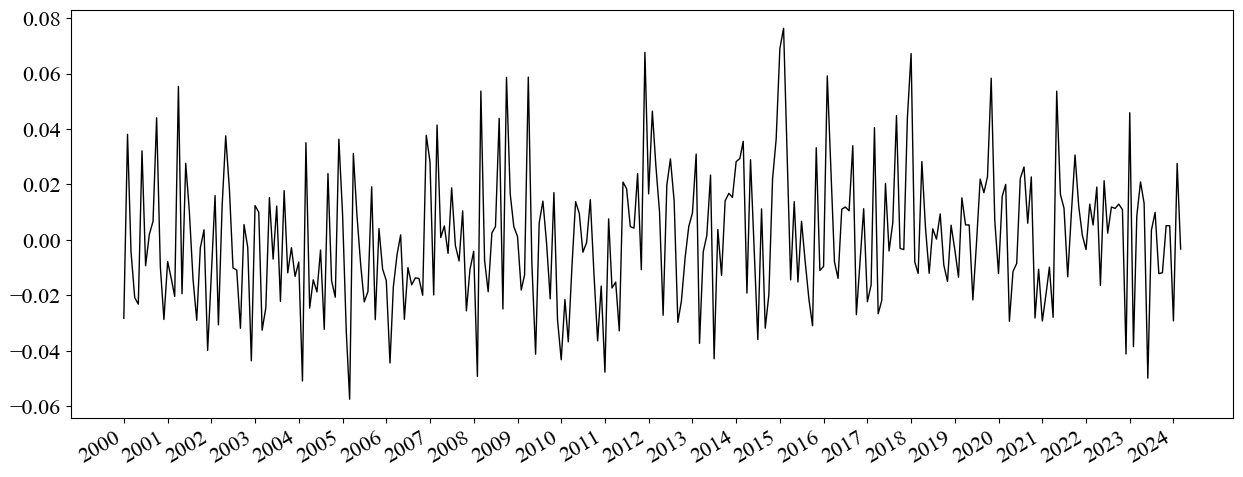

In [166]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)
#ax.plot(ds_region["time"], ds_region["velnorm"].mean(dim="longitude").mean(dim="latitude"))
ax.plot(ds_region["time"], ds_region["velnorm_anomalies"].mean(dim="longitude").mean(dim="latitude"), 
        "k-", lw=1)
ax.set_xticks([datetime.date(yyyy, 1, 1) for yyyy in range(2000, 2025)])
ax.set_xticklabels(range(2000, 2025))
fig.autofmt_xdate()

In [186]:
ppp = np.asanyarray(ds_region.time[0])
ppp

array('2000-01-01T00:00:00.000000000', dtype='datetime64[ns]')

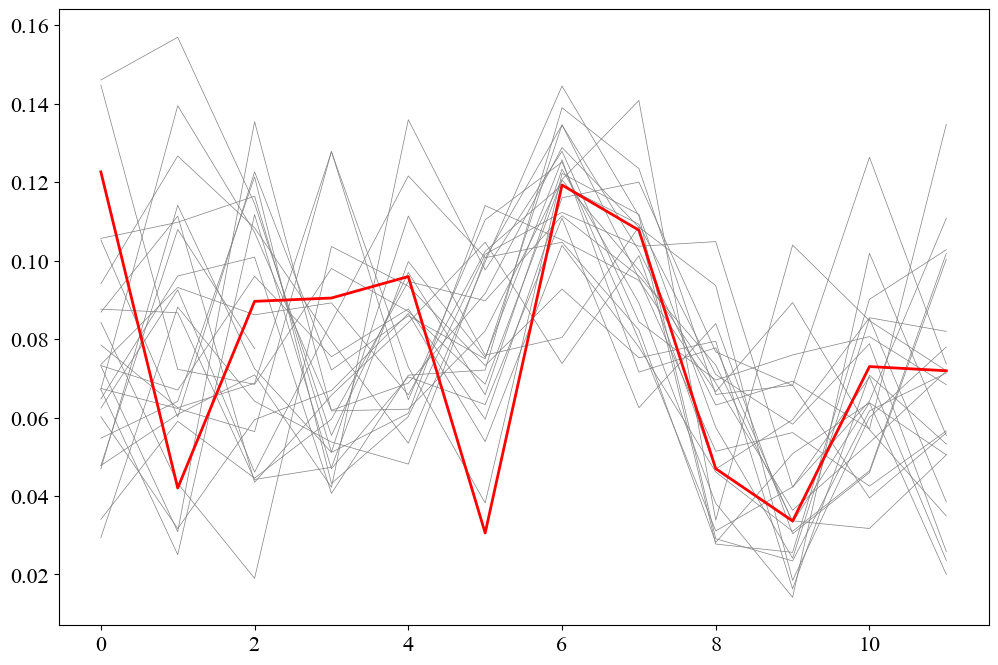

In [196]:
year_idxs = ds.groupby('time.year').groups
for yyyy in range(2000, 2025):
    plt.plot(ds_region.velnorm[year_idxs[yyyy]].mean(dim="longitude").mean(dim="latitude"), 
             "-", color=".5", lw=.5)
yyyy = 2023
plt.plot(ds_region.velnorm[year_idxs[yyyy]].mean(dim="longitude").mean(dim="latitude"), 
         "-", color="r", lw=2)

# Plots to check
## Quiver plot

In [154]:
llon, llat = np.meshgrid(ds_region["longitude"], ds_region["latitude"])

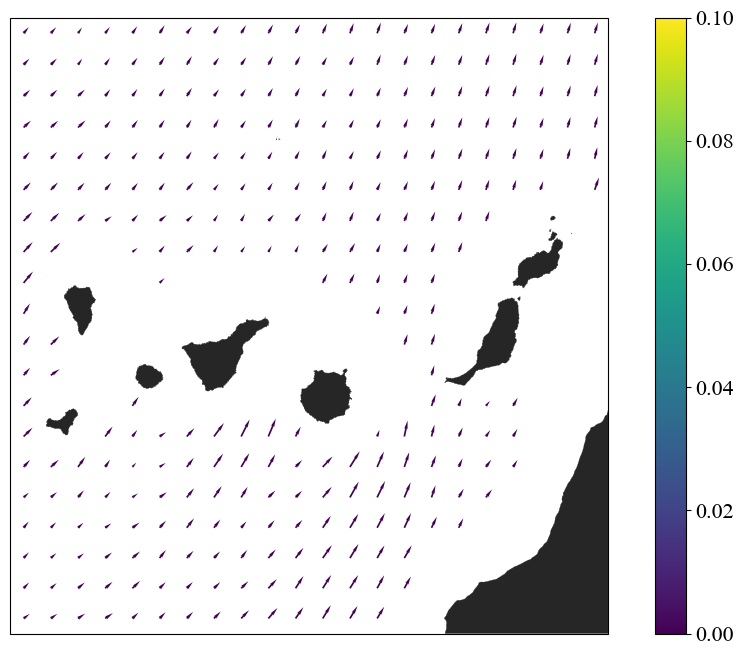

In [161]:
fig = plt.figure()
ax = plt.subplot(111, projection=myproj)
ax.set_extent(coordinates)
ax.add_feature(coast_f, linewidth=.2, color=".15", zorder=5)
quiv = ax.quiver(llon[::NN,::NN], llat[::NN,::NN], 
           np.asanyarray(ds_region["eastward_stress_anomalies"][-10,::NN,::NN]), 
           np.asanyarray(ds_region["northward_stress_anomalies"][-10,::NN,::NN]), 
           np.asanyarray(ds_region.velnorm_anomalies[-10,::NN,::NN]),
           headwidth=2, scale=3, transform=filament.datacrs, clim=(0., 0.1))
plt.colorbar(quiv)